In [1]:
import numpy as np 
import pandas as pd 
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
df_data2 = df.iloc[:, 1:7]

df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


> <h3> Extracting Eye Diseases information from the Dataset </h3>

In [3]:
def search_keywords(data_frame, keyword):
    left_diagnosis = data_frame[data_frame['Left-Diagnostic Keywords'].str.contains(keyword)]['Left-Fundus'].values
    right_diagnosis = data_frame[data_frame['Right-Diagnostic Keywords'].str.contains(keyword)]['Right-Fundus'].values
    combined = np.concatenate((left_diagnosis, right_diagnosis))
    
    return combined

# Daftar kata kunci yang ingin dicari
keywords = ["cataract", "normal", "myopia", "hypertensive", "diabetic", "age-related macular degeneration", "glaucoma"]

# Mencari semua kata kunci dalam satu langkah
class_images_dict_updated = []

for keyword in keywords:
    images_for_keyword = search_keywords(df_data2, keyword)
    class_label = keyword  # Ganti dengan label kelas yang sesuai dengan kata kunci
    image_dict = {'keyword': keyword, 'class': class_label, 'images': images_for_keyword.tolist()}
    class_images_dict_updated.append(image_dict)
#     print(f"Keyword: {keyword}, Class: {class_label}, Number of Images: {len(image_dict['images'])}")

# Menampilkan jumlah gambar untuk setiap kata kunci
for item in class_images_dict_updated:
    print(f"Number of images for {item['keyword']}: {len(item['images'])}")

# Combine all images for normal and conditions
all_images = np.concatenate([np.array(item['images']) for item in class_images_dict_updated], axis=0)
print("Total number of images:", len(all_images))

# # Menampilkan hasil pencarian untuk setiap kata kunci
# for item in class_images_dict_updated:
#     print(f"{{\n    'keyword': '{item['keyword']}',\n    'class': '{item['class']}',\n    'images': {item['images']}\n}}")
#     print()

Number of images for cataract: 594
Number of images for normal: 5683
Number of images for myopia: 479
Number of images for hypertensive: 382
Number of images for diabetic: 165
Number of images for age-related macular degeneration: 551
Number of images for glaucoma: 616
Total number of images: 8470


><h3>Creating Dataset from images (Oversample)</h3>

In [4]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
import tensorflow_addons as tfa

IMG_SIZE = 224

def load_prep_img(image_path, target_shape=(IMG_SIZE, IMG_SIZE)):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    non_0_rows = np.array([row_idx for row_idx, row in enumerate(img) if np.count_nonzero(row)!=0])
    non_0_cols = np.array([col_idx for col_idx, col in enumerate(img.transpose(1,0,2)) if np.count_nonzero(col)!=0])
    img = img[non_0_rows.min():non_0_rows.max()+1, non_0_cols.min():non_0_cols.max()+1, :] # clip
    img = cv2.resize(img, target_shape)
    return img

# def get_gaussian_filter_shape(IMG_SIZE):
#     return IMG_SIZE//4 - 1

# def blur_image(image, sigma=10):
#     filter_shape = get_gaussian_filter_shape(image.shape[0])  # Menggunakan image.shape[0]
#     return tfa.image.gaussian_filter2d(image, filter_shape=filter_shape, sigma=sigma)

# def weighted_image(image, alpha=4, beta=-4, gamma=128):
#     return image*alpha + blur_image(image)*beta + gamma

# Fungsi untuk Gaussian blur menggunakan cv2.GaussianBlur
def gaussian_blur(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)

# Fungsi untuk melakukan histogram equalization pada gambar
def histogram_equalization(image):
    # Ubah gambar ke skala keabuan jika belum
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    # Lakukan histogram equalization
    equalized = cv2.equalizeHist(gray)
    equalized = cv2.cvtColor(equalized, cv2.COLOR_GRAY2RGB)
    filtered = gaussian_blur(equalized)
#     weighted = weighted_image(equalized)
    return filtered

# Fungsi untuk melakukan histogram equalization pada gambar
def clahe(image):
    # Ubah gambar ke skala keabuan jika belum
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
    enhanced_image = clahe.apply(gray)
    enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2BGR)
    filtered = gaussian_blur(enhanced_image)
#     weighted = weighted_image(enhanced_image)
    return filtered

def create_dataset_with_oversampling(dataset_dir, class_images_dict_updated, image_size=(224, 224)):
    tracked_images = []

    # Tracking image labels from class_images_dict
    for entry in tqdm(class_images_dict_updated, desc="Tracking image label"):
        keyword = entry['keyword']
        class_label = entry['class']
        image_files = entry['images']
        
        for image_file in image_files:
            image_path = os.path.join(dataset_dir, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                # Apply preprocessing steps
                image = load_prep_img(image_path)
                tracked_images.append((image, class_label))

    # Separating images and labels into two separate lists
    tracked_images_list = [(x[0], x[1]) for x in tracked_images]
    images_list, labels_list = zip(*tracked_images_list)

    # Create the initial dataset
    class_label_mapping = {class_name: idx for idx, class_name in enumerate(set(labels_list))}
    dataset = [(images_list[i], class_label_mapping[labels_list[i]]) for i in range(len(images_list))]

    # Convert the dataset to a DataFrame
    df = pd.DataFrame(dataset, columns=['image', 'label'])
    
    # Convert labels to integers explicitly
    df['label'] = df['label'].astype(int)
    
#     # Apply SMOTE oversampling
#     smote = SMOTE(sampling_strategy='auto', random_state=42)

#     # Flatten the image arrays
#     X_flat = np.array([img.flatten() for img in df['image']])
#     X_resampled, y_resampled = smote.fit_resample(X_flat, df['label'])

#     # Assuming the original image size is (224, 224, 3)
#     original_shape = (224, 224, 3)

#     # Reshape the flattened images to their original shapes
#     X_resampled_reshaped = np.array([img.reshape(original_shape) for img in X_resampled])

#     # Apply CLAHE to the oversampled images
#     resampled_dataset = [(clahe(X_resampled_reshaped[i]), y_resampled[i]) for i in range(len(X_resampled_reshaped))]
    
#     # Apply HE to the oversampled images
#     resampled_dataset = [(histogram_equalization(X_resampled_reshaped[i]), y_resampled[i]) for i in range(len(X_resampled_reshaped))]
    
    # Apply random oversampling
    oversample = RandomOverSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = oversample.fit_resample(df['image'].values.reshape(-1, 1), df['label'])
    
    # Reconstruct the dataset and apply CLAHE
    resampled_dataset = [(clahe(X_resampled[i][0]), y_resampled[i]) for i in range(len(X_resampled))]
    
#     # Reconstruct the dataset and HE
#     resampled_dataset = [(histogram_equalization(X_resampled[i][0]), y_resampled[i]) for i in range(len(X_resampled))]

    random.shuffle(resampled_dataset)

     # Print original class distribution
    print("Original Class Distribution:")
    for class_name in set(labels_list):
        class_count = df[df['label'] == class_label_mapping[class_name]]['label'].count()
        print(f"{class_name}: {class_count}")

    # Print oversampled class distribution
    print("\nOversampled Class Distribution:")
    resampled_df = pd.DataFrame({'label': y_resampled})
    for class_name in set(labels_list):
        class_count = resampled_df[resampled_df['label'] == class_label_mapping[class_name]]['label'].count()
        print(f"{class_name}: {class_count}")
    return resampled_dataset, list(set(labels_list))

dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
# dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/"
dataset, labels = create_dataset_with_oversampling(dataset_dir, class_images_dict_updated)
print("Total number of images in the dataset:", len(dataset))

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
Tracking image label:   0%|          | 0/7 [00:00<?, ?it/s][ WARN:0@13.725] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2102_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@15.476] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2231_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@15.661] global loadsave.c

Original Class Distribution:
hypertensive: 381
myopia: 473
diabetic: 159
cataract: 588
age-related macular degeneration: 551
normal: 5596
glaucoma: 613

Oversampled Class Distribution:
hypertensive: 5596
myopia: 5596
diabetic: 5596
cataract: 5596
age-related macular degeneration: 5596
normal: 5596
glaucoma: 5596
Total number of images in the dataset: 39172


><h3>Creating Dataset from images (No Handling)</h3>

In [5]:
# IMG_SIZE = 224

# def load_prep_img(image_path, target_shape=(IMG_SIZE, IMG_SIZE)):
#     img = cv2.imread(image_path, cv2.IMREAD_COLOR)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
#     non_0_rows = np.array([row_idx for row_idx, row in enumerate(img) if np.count_nonzero(row)!=0])
#     non_0_cols = np.array([col_idx for col_idx, col in enumerate(img.transpose(1,0,2)) if np.count_nonzero(col)!=0])
#     img = img[non_0_rows.min():non_0_rows.max()+1, non_0_cols.min():non_0_cols.max()+1, :] # clip
#     img = cv2.resize(img, target_shape)
#     return img

# # Fungsi untuk Gaussian blur menggunakan cv2.GaussianBlur
# def gaussian_blur(image, kernel_size=(5, 5)):
#     return cv2.GaussianBlur(image, kernel_size, 0)

# # Fungsi untuk melakukan histogram equalization pada gambar
# def histogram_equalization(image):
#     # Ubah gambar ke skala keabuan jika belum
#     if len(image.shape) > 2:
#         gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     else:
#         gray = image

#     # Lakukan histogram equalization
#     equalized = cv2.equalizeHist(gray)
#     equalized = cv2.cvtColor(equalized, cv2.COLOR_GRAY2RGB)
#     filtered = gaussian_blur(equalized)
#     return filtered

# # Fungsi untuk melakukan histogram equalization pada gambar
# def clahe(image):
#     # Ubah gambar ke skala keabuan jika belum
#     if len(image.shape) > 2:
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     else:
#         gray = image

#     clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(10,10))
#     enhanced_image = clahe.apply(gray)
#     enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2BGR)
#     filtered = gaussian_blur(enhanced_image)
#     return filtered

# def create_dataset(dataset_dir, class_images_dict, image_size=(224, 224)):
#     dataset = []
#     labels = list(class_images_dict.keys())

#     for class_name, image_category in class_images_dict.items():
#         for img in tqdm(image_category, desc=f"Processing {class_name} images"):
#             image_path = os.path.join(dataset_dir, img)
#             try:
#                 image = load_prep_img(image_path)
# #                 image = histogram_equalization(image)
#                 image = clahe(image)
#             except:
#                 continue

#             # Assuming the class labels are encoded as integers
#             label = np.array(labels.index(class_name))
            
#             dataset.append([np.array(image), label])

#     random.shuffle(dataset)
#     return dataset, labels

# # Placeholder arrays, replace these with actual arrays when available
# cataract = class_images_dict.get('cataract', [])
# normal = class_images_dict.get('normal', [])
# diabetic = class_images_dict.get('diabetic', [])
# amd = class_images_dict.get('age-related macular degeneration', [])
# glaucoma = class_images_dict.get('glaucoma', [])
# myopia = class_images_dict.get('myopia', [])
# hypertensive = class_images_dict.get('hypertensive', [])

# # Assuming you have a dictionary of class images
# class_images_dict = {
#     'cataract': cataract,
#     'normal': normal,
#     'diabetic': diabetic,
#     'age-related macular degeneration': amd,
#     'glaucoma': glaucoma,
#     'myopia': myopia,
#     'hypertensive': hypertensive
# }

# dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
# dataset, labels = create_dataset(dataset_dir, class_images_dict)
# print("Total number of images in the dataset:", len(dataset))

><h3>Creating Dataset from images (Undersample)</h3>

In [6]:
# from imblearn.under_sampling import RandomUnderSampler
# import tensorflow_addons as tfa

# IMG_SIZE = 224

# def load_prep_img(image_path, target_shape=(IMG_SIZE, IMG_SIZE)):
#     img = cv2.imread(image_path, cv2.IMREAD_COLOR)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
#     non_0_rows = np.array([row_idx for row_idx, row in enumerate(img) if np.count_nonzero(row)!=0])
#     non_0_cols = np.array([col_idx for col_idx, col in enumerate(img.transpose(1,0,2)) if np.count_nonzero(col)!=0])
#     img = img[non_0_rows.min():non_0_rows.max()+1, non_0_cols.min():non_0_cols.max()+1, :] # clip
#     img = cv2.resize(img, target_shape)
#     return img

# # def get_gaussian_filter_shape(IMG_SIZE):
# #     return IMG_SIZE//4 - 1

# # def blur_image(image, sigma=10):
# #     filter_shape = get_gaussian_filter_shape(image.shape[0])  # Menggunakan image.shape[0]
# #     return tfa.image.gaussian_filter2d(image, filter_shape=filter_shape, sigma=sigma)

# # def weighted_image(image, alpha=4, beta=-4, gamma=128):
# #     return image*alpha + blur_image(image)*beta + gamma

# # Fungsi untuk Gaussian blur menggunakan cv2.GaussianBlur
# def gaussian_blur(image, kernel_size=(5, 5)):
#     return cv2.GaussianBlur(image, kernel_size, 0)

# # Fungsi untuk melakukan histogram equalization pada gambar
# def histogram_equalization(image):
#     # Ubah gambar ke skala keabuan jika belum
#     if len(image.shape) > 2:
#         gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     else:
#         gray = image

#     # Lakukan histogram equalization
#     equalized = cv2.equalizeHist(gray)
#     equalized = cv2.cvtColor(equalized, cv2.COLOR_GRAY2RGB)
#     filtered = gaussian_blur(equalized)
# #     weighted = weighted_image(equalized)
#     return filtered

# # Fungsi untuk melakukan histogram equalization pada gambar
# def clahe(image):
#     # Ubah gambar ke skala keabuan jika belum
#     if len(image.shape) > 2:
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     else:
#         gray = image

#     clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
#     enhanced_image = clahe.apply(gray)
#     enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2BGR)
#     filtered = gaussian_blur(enhanced_image)
# #     weighted = weighted_image(enhanced_image)
#     return filtered

# def create_dataset_with_oversampling(dataset_dir, class_images_dict_updated, image_size=(224, 224)):
#     tracked_images = []

#     # Tracking image labels from class_images_dict
#     for entry in tqdm(class_images_dict_updated, desc="Tracking image label"):
#         keyword = entry['keyword']
#         class_label = entry['class']
#         image_files = entry['images']
        
#         for image_file in image_files:
#             image_path = os.path.join(dataset_dir, image_file)
#             image = cv2.imread(image_path)
#             if image is not None:
#                 # Apply preprocessing steps
#                 image = load_prep_img(image_path)
#                 tracked_images.append((image, class_label))

#     # Separating images and labels into two separate lists
#     tracked_images_list = [(x[0], x[1]) for x in tracked_images]
#     images_list, labels_list = zip(*tracked_images_list)

#     # Create the initial dataset
#     class_label_mapping = {class_name: idx for idx, class_name in enumerate(set(labels_list))}
#     dataset = [(images_list[i], class_label_mapping[labels_list[i]]) for i in range(len(images_list))]

#     # Convert the dataset to a DataFrame
#     df = pd.DataFrame(dataset, columns=['image', 'label'])
    
#     # Convert labels to integers explicitly
#     df['label'] = df['label'].astype(int)

#     # Apply random undersampling
#     undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
#     X_resampled, y_resampled = undersample.fit_resample(df['image'].values.reshape(-1, 1), df['label'])
    
#     # Reconstruct the dataset for CLAHE
#     resampled_dataset = [(clahe(X_resampled[i][0]), y_resampled[i]) for i in range(len(X_resampled))]
    
# #     # Reconstruct the dataset for HE
# #     resampled_dataset = [(histogram_equalization(X_resampled[i][0]), y_resampled[i]) for i in range(len(X_resampled))]

#     random.shuffle(resampled_dataset)

#      # Print original class distribution
#     print("Original Class Distribution:")
#     for class_name in set(labels_list):
#         class_count = df[df['label'] == class_label_mapping[class_name]]['label'].count()
#         print(f"{class_name}: {class_count}")

#     # Print oversampled class distribution
#     print("\nOversampled Class Distribution:")
#     resampled_df = pd.DataFrame({'label': y_resampled})
#     for class_name in set(labels_list):
#         class_count = resampled_df[resampled_df['label'] == class_label_mapping[class_name]]['label'].count()
#         print(f"{class_name}: {class_count}")
#     return resampled_dataset, list(set(labels_list))

# dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
# # dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/"
# dataset, labels = create_dataset_with_oversampling(dataset_dir, class_images_dict_updated)
# print("Total number of images in the dataset:", len(dataset))

><h3>Let's see some images</h3>

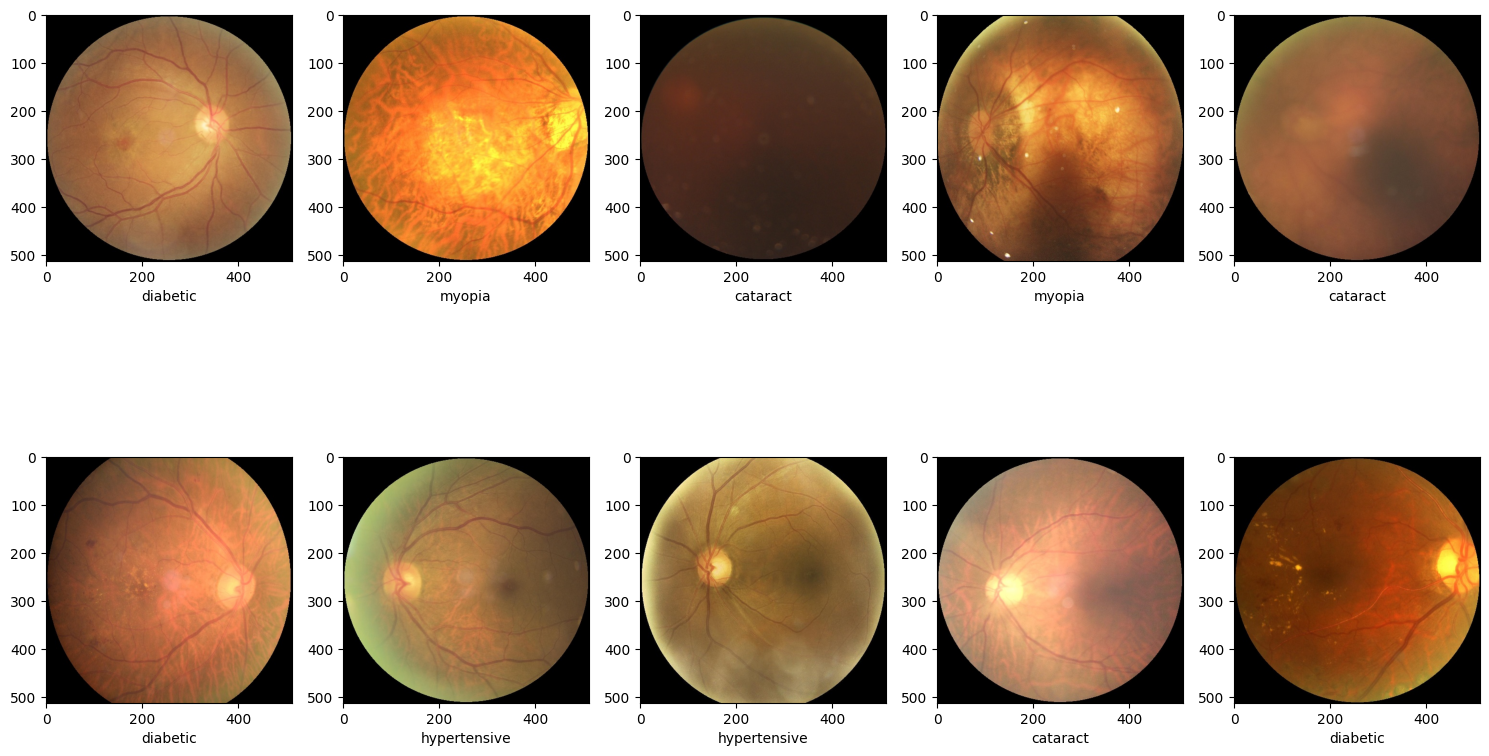

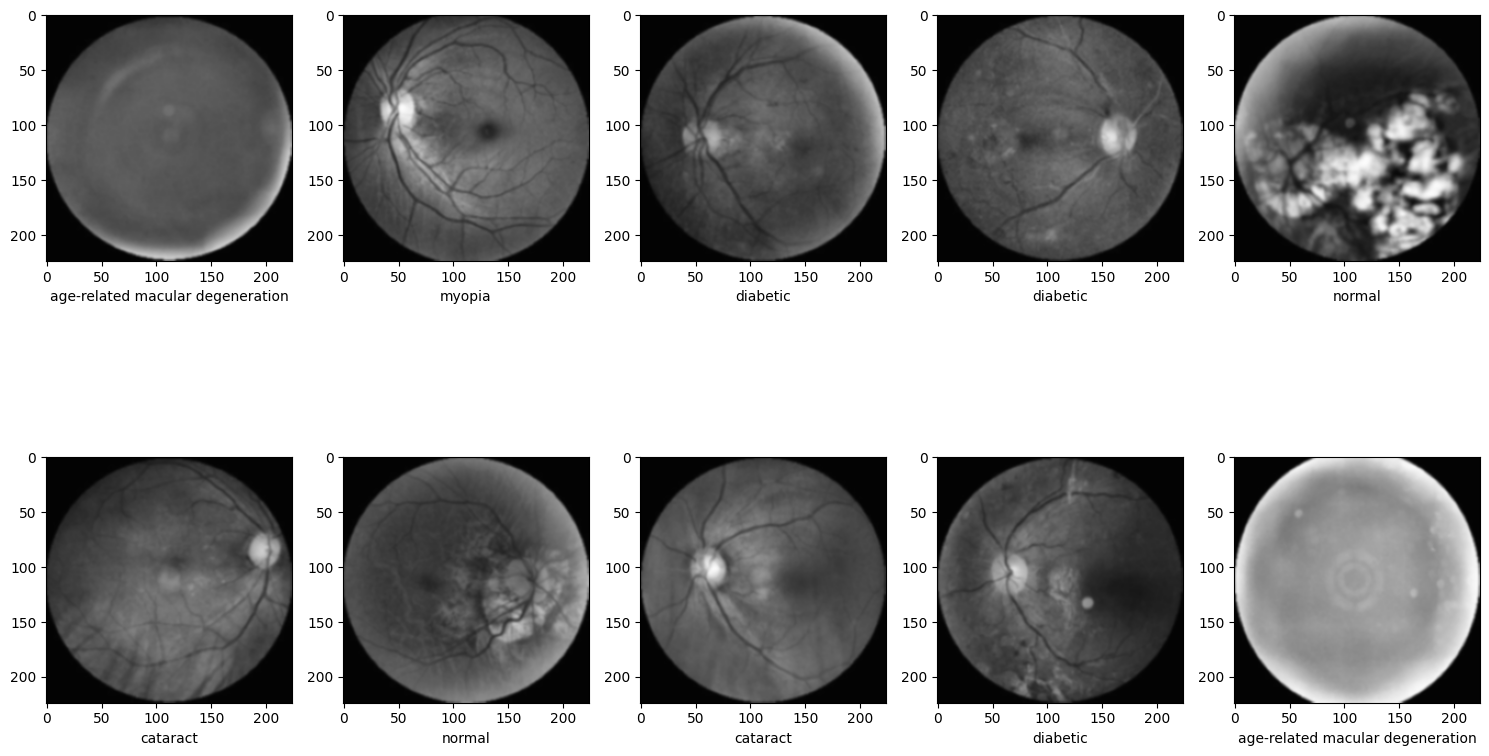

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# def display_sample_images(image_paths, title="Sample Images"):
#     plt.figure(figsize=(15, 10))
#     for i, image_path in enumerate(image_paths):
#         plt.subplot(2, len(image_paths)//2, i + 1)
#         img = mpimg.imread(image_path)
#         plt.imshow(img)
#         plt.axis('off')

#     plt.suptitle(title, fontsize=16)
#     plt.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.show()

# # Mengambil beberapa path gambar dari beberapa kategori sebelum SMOTE
# sample_paths = []
# for category in ['normal', 'diabetic', 'age-related macular degeneration', 'glaucoma', 'myopia', 'hypertensive']:
#     sample_paths.extend([os.path.join(dataset_dir, img) for img in random.sample(class_images_dict_updated[category], 2)])

# # Menampilkan contoh gambar dari beberapa kategori sebelum SMOTE
# display_sample_images(sample_paths, title="Sample Images Before SMOTE")

# Gantilah X dan y dengan variabel yang sesuai pada saat membuat dataset
plt.figure(figsize=(15, 10))
for i in range(10):
    # Choose a random sample from class_images_dict_updated
    sample = random.choice(class_images_dict_updated)
    image_file = random.choice(sample['images'])
    image_path = os.path.join(dataset_dir, image_file)
    image = mpimg.imread(image_path)
    
    class_label = sample['class']
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.xlabel(class_label)

plt.tight_layout()
plt.show()

# Gantilah X dan y dengan variabel yang sesuai pada saat membuat dataset
plt.figure(figsize=(15, 10))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    label_id = dataset[sample][1]
    
    # Konversi label_id ke label yang sesuai
    labels = ['cataract', 'normal', 'diabetic', 'age-related macular degeneration', 'glaucoma', 'myopia', 'hypertensive']
    label = labels[label_id]
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.xlabel(label)

plt.tight_layout()
plt.show()

><h3>Dividing dataset into x(features) & y(target)</h3>

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical, normalize

# Assuming num_classes is defined and set to 7
num_classes = 7

# Convert labels to one-hot encoded format
y = np.array([i[1] for i in dataset])
y_onehot = to_categorical(y, num_classes=num_classes)

In [9]:
# Split the dataset into training and testing sets
image_size=224
x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
# x_train, x_test, y_train, y_test = train_test_split(x, y_onehot, test_size=0.3)

import os
import shutil
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Fungsi untuk membuat folder output
def create_output_folders(output_folder, labels):
    os.makedirs(output_folder, exist_ok=True)

    # Hapus konten folder output jika ada
    for label in labels:
        label_folder = os.path.join(output_folder, label)
        shutil.rmtree(label_folder, ignore_errors=True)
        os.makedirs(label_folder, exist_ok=True)

#Split data menggunakan train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

#Encode Y labels to 0, 1, 2, 3, then one hot encode. 
le = LabelEncoder()
le.fit(y_train)
y_train_deep = le.transform(y_train)
y_train_deep_cat = to_categorical(y_train_deep)

y_test_deep = le.transform(y_test)
y_test_deep_cat = to_categorical(y_test_deep)

# Mengambil nama kelas dari labels
class_names = [str(label) for label in range(num_classes)]

# Folder untuk menyimpan gambar-gambar hasil konversi
output_folder = "/kaggle/working/output/"

# Membuat folder output jika belum ada
os.makedirs(output_folder, exist_ok=True)

# Membuat folder output untuk training dan testing
train_output_folder = os.path.join(output_folder, 'train')
test_output_folder = os.path.join(output_folder, 'test')
create_output_folders(train_output_folder, class_names)
create_output_folders(test_output_folder, class_names)

# Menyimpan data training ke dalam folder
for i in tqdm(range(len(x_train)), desc="Saving training data"):
    img, label = x_train[i], y_train_deep_cat[i]
    class_name = class_names[np.argmax(label)]
    img_filename = f"{i}.png"  # Ganti dengan format nama file yang sesuai
    img_path = os.path.join(train_output_folder, class_name, img_filename)
    cv2.imwrite(img_path, img)

# Menyimpan data testing ke dalam folder
for i in tqdm(range(len(x_test)), desc="Saving testing data"):
    img, label = x_test[i], y_test_deep_cat[i]
    class_name = class_names[np.argmax(label)]
    img_filename = f"{i}.png"  # Ganti dengan format nama file yang sesuai
    img_path = os.path.join(test_output_folder, class_name, img_filename)
    cv2.imwrite(img_path, img)

print("Proses split dan penyimpanan data selesai.")

# # Split the dataset into training and testing sets
# image_size=224
# x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
# # x_train, x_test, y_train, y_test = train_test_split(x, y_onehot, test_size=0.3)

# # Split data menggunakan train_test_split
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# #Encode Y labels to 0, 1, 2, 3, then one hot encode. 
# le = LabelEncoder()
# le.fit(y_train)
# y_train_deep = le.transform(y_train)
# y_train_deep_cat = to_categorical(y_train_deep)

# y_test_deep = le.transform(y_test)
# y_test_deep_cat = to_categorical(y_test_deep)

Saving testing data: 100%|██████████| 11752/11752 [00:26<00:00, 440.01it/s]

Proses split dan penyimpanan data selesai.


><h3>Creating Model</h3>

In [10]:
from keras.applications.mobilenet import MobileNet, preprocess_input
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))

17225924/17225924 [==============================] - 1s 0us/step


In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
from keras import applications, regularizers
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D

num_classes = 7

model = Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [13]:
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler

# Learning Rate Schedule
def lr_schedule(epoch):
    lr = 0.01
    if epoch > 10:
        lr *= 0.1
    elif epoch > 5:
        lr *= 0.5
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard

checkpoint = ModelCheckpoint('model_mobilenet.save', monitor='val_loss', save_best_only=True, verbose=1,save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
log_dir = "logs/fit_vgg/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [15]:
input_shape = (224, 224, 3)

# Membuat objek ImageDataGenerator tanpa augmentasi
datagen = ImageDataGenerator()

# Menggunakan flow_from_directory untuk mendapatkan data training dan testing
train_generator = datagen.flow_from_directory(
    train_output_folder,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_output_folder,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical'
)

# Melatih model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    verbose=1,
    callbacks=[checkpoint,earlystop, lr_scheduler]
)

# history = model.fit(x_train, y_train_deep_cat, epochs=50, validation_data = (x_test, y_test_deep_cat),
#                    verbose=1, callbacks=[checkpoint,earlystop, lr_scheduler])

Found 27420 images belonging to 7 classes.
Found 11752 images belonging to 7 classes.
Epoch 1/50
857/857 [==============================] - ETA: 0s - loss: 1.1688 - accuracy: 0.5817
Epoch 1: val_loss improved from inf to 3.78663, saving model to model_mobilenet.save
857/857 [==============================] - 127s 126ms/step - loss: 1.1688 - accuracy: 0.5817 - val_loss: 3.7866 - val_accuracy: 0.3797 - lr: 0.0100
Epoch 2/50
857/857 [==============================] - ETA: 0s - loss: 0.5489 - accuracy: 0.8224
Epoch 2: val_loss improved from 3.78663 to 0.63934, saving model to model_mobilenet.save
857/857 [==============================] - 105s 123ms/step - loss: 0.5489 - accuracy: 0.8224 - val_loss: 0.6393 - val_accuracy: 0.8096 - lr: 0.0100
Epoch 3/50
857/857 [==============================] - ETA: 0s - loss: 0.4015 - accuracy: 0.8743
Epoch 3: val_loss did not improve from 0.63934
857/857 [==============================] - 93s 109ms/step - loss: 0.4015 - accuracy: 0.8743 - val_loss: 0.778

In [16]:
# loss, accuracy = model.evaluate(x_test, y_test_deep_cat, verbose=0)
# print('Loss: %.2f' % (loss*100))
# print('Accuracy: %.2f' % (accuracy*100))

# Evaluate the keras model using test_generator
evaluation = model.evaluate(test_generator, verbose=0)

# Extract loss and accuracy from the evaluation results
loss = evaluation[0]
accuracy = evaluation[1]

print('Loss: %.2f' % (loss * 100))
print('Accuracy: %.2f' % (accuracy * 100))

Loss: 9.31
Accuracy: 95.93


><h3>Learning Curve</h3>

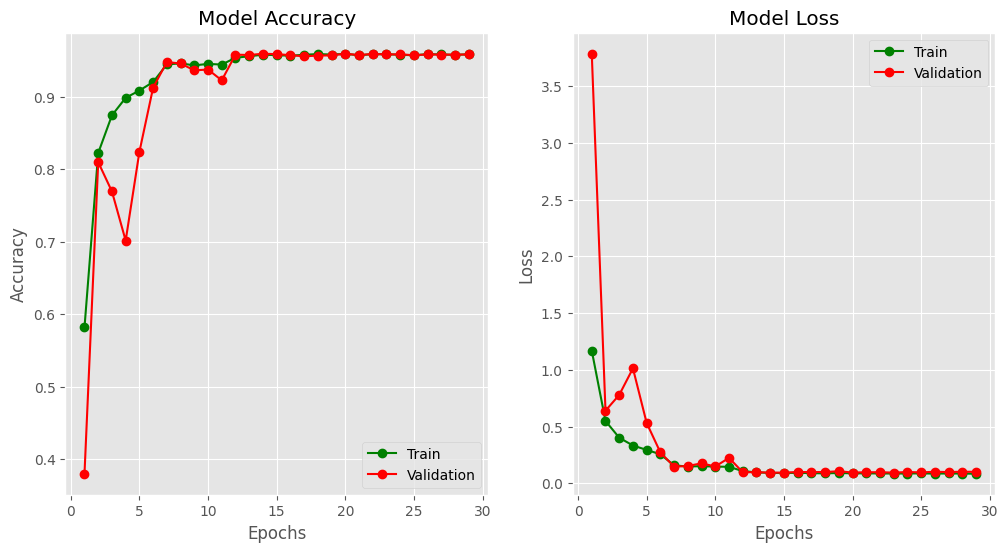

In [17]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12, 6))

# Extract the actual number of epochs from the training history
epochs = range(1, len(history.history['accuracy']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper right")

plt.show()

368/368 [==============================] - 9s 23ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1642
           1       0.98      0.99      0.98      1672
           2       0.89      1.00      0.94      1720
           3       0.99      0.99      0.99      1666
           4       0.94      0.94      0.94      1691
           5       1.00      0.98      0.99      1658
           6       0.97      0.89      0.93      1703

    accuracy                           0.96     11752
   macro avg       0.96      0.96      0.96     11752
weighted avg       0.96      0.96      0.96     11752

Confusion Matrix:
[[1524    0   67   10   28    0   13]
 [   0 1656    0    0    4    0   12]
 [   0    0 1720    0    0    0    0]
 [  18    0    0 1642    0    0    6]
 [   3    1   87    0 1597    0    3]
 [   2    6    0    6    8 1624   12]
 [  35   30   62    5   60    0 1511]]


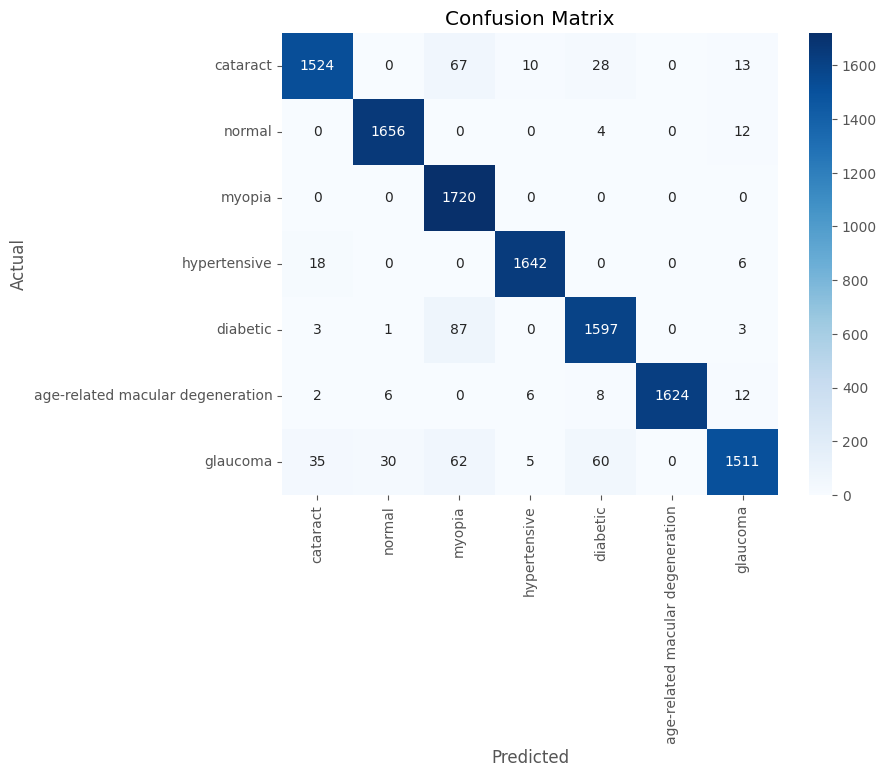


Class 0 (cataract):
  AUC-ROC: 0.9988
  Precision: 0.9633
  Recall: 0.9281
  Specificity: 0.9943
  F1-score: 0.9454
  Accuracy: 0.9850

Class 1 (normal):
  AUC-ROC: 0.9998
  Precision: 0.9781
  Recall: 0.9904
  Specificity: 0.9963
  F1-score: 0.9842
  Accuracy: 0.9955

Class 2 (myopia):
  AUC-ROC: 0.9949
  Precision: 0.8884
  Recall: 1.0000
  Specificity: 0.9785
  F1-score: 0.9409
  Accuracy: 0.9816

Class 3 (hypertensive):
  AUC-ROC: 0.9999
  Precision: 0.9874
  Recall: 0.9856
  Specificity: 0.9979
  F1-score: 0.9865
  Accuracy: 0.9962

Class 4 (diabetic):
  AUC-ROC: 0.9982
  Precision: 0.9411
  Recall: 0.9444
  Specificity: 0.9901
  F1-score: 0.9427
  Accuracy: 0.9835

Class 5 (age-related macular degeneration):
  AUC-ROC: 0.9978
  Precision: 1.0000
  Recall: 0.9795
  Specificity: 1.0000
  F1-score: 0.9896
  Accuracy: 0.9971

Class 6 (glaucoma):
  AUC-ROC: 0.9977
  Precision: 0.9705
  Recall: 0.8873
  Specificity: 0.9954
  F1-score: 0.9270
  Accuracy: 0.9797


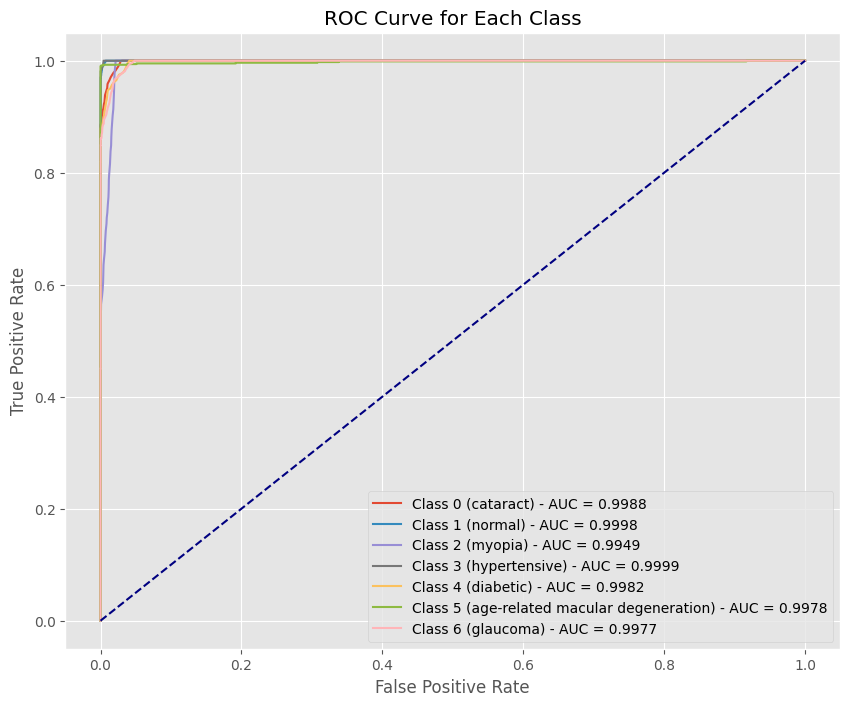

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns

# Ambil true labels dari y_test_deep_cat (tidak one-hot encoded)
y_true = np.argmax(y_test_deep_cat, axis=1)

# Prediksi probabilitas menggunakan model pada data test
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Tampilkan classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Tampilkan confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

class_names = ["cataract", "normal", "myopia", "hypertensive", "diabetic", "age-related macular degeneration", "glaucoma"]

# Visualisasi confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Kalkulasi dan tampilkan AUC-ROC serta metrics untuk setiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()

precision = dict()
recall = dict()
specificity = dict()
f1_score = dict()
accuracy = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i] = precision_score(y_true == i, y_pred == i)
    recall[i] = recall_score(y_true == i, y_pred == i)
    
    tn, fp, fn, tp = confusion_matrix(y_true == i, y_pred == i).ravel()
    specificity[i] = tn / (tn + fp)
    f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
    accuracy[i] = accuracy_score(y_true == i, y_pred == i)

    print(f"\nClass {i} ({class_names[i]}):")
    print(f"  AUC-ROC: {roc_auc[i]:.4f}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  Specificity: {specificity[i]:.4f}")
    print(f"  F1-score: {f1_score[i]:.4f}")
    print(f"  Accuracy: {accuracy[i]:.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ({class_names[i]}) - AUC = {roc_auc[i]:.4f}')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()